In [1]:
import torch
from dct_lee import DCT, IDCT
a = torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]]).cuda()
dct = DCT().cuda()
idct = IDCT().cuda()
b = dct(a)
ab = idct(b)
print(b)
print(ab)

tensor([[ 9.0000, -3.2212,  0.0000, -0.3367,  0.0000, -0.1005,  0.0000, -0.0254],
        [ 9.5000, -1.2691,  0.1913, -0.5836, -1.7678,  0.1598, -0.4619,  0.7234],
        [12.0000,  1.7947,  1.3066, -0.8253,  0.0000,  0.2260, -0.5412, -1.0231]],
       device='cuda:0')
tensor([[ 2.0000,  4.0000,  6.0000,  8.0000, 10.0000, 12.0000, 14.0000, 16.0000],
        [ 4.0000, 10.0000, 12.0000,  6.0000,  8.0000, 10.0000, 16.0000, 10.0000],
        [16.0000, 18.0000, 12.0000, 14.0000,  6.0000,  8.0000, 10.0000, 12.0000]],
       device='cuda:0')


In [7]:
import numpy as np
from scipy.fft import dct as sci_dct
from scipy.fft import idct as sci_idct
aa = np.array([1.,2.,3.,4.,5.,6.,7.,8.])
bb = sci_dct(aa, norm='ortho')
aabb = sci_idct(bb, norm='ortho')
print(bb)
print(aabb)
# match with matlab

[12.72792206 -6.44232302  0.         -0.6734548   0.         -0.2009029
  0.         -0.05070232]
[1. 2. 3. 4. 5. 6. 7. 8.]


In [2]:
import torch
from discrete_spectral_transform import dct_N
a = torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]]).cuda()
print(a.size())

torch.Size([3, 8])


In [10]:
b = dct(a)
print(b)

tensor([[ 9.0000, -3.2212,  0.0000, -0.3367,  0.0000, -0.1005,  0.0000, -0.0254],
        [ 9.5000, -1.2691,  0.1913, -0.5836, -1.7678,  0.1598, -0.4619,  0.7234],
        [12.0000,  1.7947,  1.3066, -0.8253,  0.0000,  0.2260, -0.5412, -1.0231]],
       device='cuda:0')


In [2]:
import torch
a = torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]])
b = torch.tensor([1.,1.,4.,5.,1.,4.,1.,9.])
print(torch.mul(a,b))

tensor([[ 1.,  2., 12., 20.,  5., 24.,  7., 72.],
        [ 2.,  5., 24., 15.,  4., 20.,  8., 45.],
        [ 8.,  9., 24., 35.,  3., 16.,  5., 54.]])


In [3]:
a = torch.rand((5,3840))#16bins, 256hop
b = torch.stft(a,1024,256,1024,None,True)
c = torch.stft(a,1024,256,1024,None,False)
print(b.size())
print(c.size())

torch.Size([5, 513, 16, 2])
torch.Size([5, 513, 12, 2])


/root/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:572: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [4]:
from torch import nn
from torch.nn.functional import pad
from dct_lee import DCT
class MDCT(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', device='cuda') -> None:
        super(MDCT,self).__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center

        # making window
        if callable(window):
            self.window = window(win_length).to(self.device)
            self.win_length = win_length
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth should be no more than fft length'
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'

        self.dct = DCT()

    def forward(self, signal):
        signal = signal.to(self.device)
        if self.center:
            # Pad the signal on both sides so that the t-th frame is centered at time t * hop_length. Otherwise, the t-th frame begins at time t * hop_length.
            signal = pad(signal, (self.win_length//2, self.win_length//2), mode=self.pad_mode)
        # Pad the signal to a proper length
        signal_len = int(len(signal))
        #print(signal_len)
        if (signal_len-self.win_length)%self.hop_length:
            out_len = int(torch.ceil(torch.tensor([(signal_len-self.win_length)/self.hop_length])).item() * self.hop_length + self.win_length)
        else:
            out_len = signal_len
        #print(out_len)
        signal = pad(signal, (0,out_len-signal_len), mode=self.pad_mode)
        # Slice the signal with overlapping
        #print(signal.size())
        signal = signal.unfold(dimension=-1, size=self.win_length, step=self.hop_length)
        #print(signal.size())
        # Apply windows to each pieces
        signal = torch.mul(signal, self.window)
        return self.dct(signal)

torch.Size([1024, 512])
cuda:0


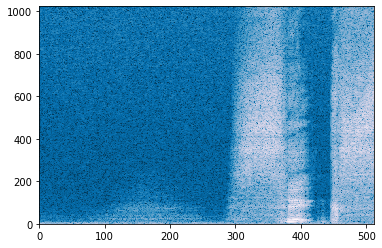

In [5]:
import torchaudio
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as aF
audio_path = '/root/VCTK-Corpus/wav48/p225/p225_003.wav'
audio, fs = torchaudio.load(audio_path)
K = 20000
audio_seg = audio[...,K:51100+1024+K]
mdct = MDCT(n_fft=1024, hop_length=100, win_length=1024, window=torch.kaiser_window, center=False)
spectro = mdct(audio_seg.cuda().squeeze(0))
spectro = aF.amplitude_to_DB((spectro.abs() + 1e-7),20,1e-7,1).squeeze(0).permute(1,0)
print(spectro.size())
print(spectro.device)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(spectro.cpu().numpy(), cmap='PuBu_r')
plt.show()